## Solve IVP using PINN

- Subject: Physics-informed Neural Networks
- Reference:
- created: 2024.11.16

### Problem

Solve an inital value problem:

$$\frac{du}{dt} = \cos(2\pi t),\quad u(0)=1,\quad t\in[0,2]$$

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import warnings
warnings.filterwarnings(action="ignore")

In [13]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

### Loss Functions and Data

In [26]:
def gradient(y, x):
    return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y),
                create_graph=True, retain_graph=True)[0]

def to_tensor(x):
    return torch.tensor(x).float().to(device)

In [27]:
def u_exact(t):
    return np.sin(2*np.pi*t)/(2*np.pi) + 1

def residual_loss(model, t):
    t.requires_grad = True
    u = model(t)
    u_t = gradient(u, t)
    residual = u_t - torch.cos(2 * np.pi * t)
    return torch.mean(residual**2)

## Collocation points (Domain): residual loss
t_np = np.linspace(0, 2, 51)
t = to_tensor(t_np)

## Initial points: initial condition loss
t0 = to_tensor(0)
u0 = to_tensor(1)

## Data points: data loss
n_data = 20
t_data_np = np.linspace(0.25, 1, n_data) + np.random.randn(n_data) * 0.01
u_data_np = u_exact(t_data_np) +  np.random.randn(n_data) * 0.02

t_data = to_tensor(t_data_np)
u_data = to_tensor(u_data_np)

### Modeling and Training

In [31]:
from pinn import MLP

class PINN(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.model = MLP(layer_sizes, activation=nn.Tanh())

    def forward(self, t):
        t = t.unsqueeze(-1)     # t = t.view(-1, 1) or t = t[:, None]
        return self.model(t).squeeze()

Epoch[10000/10000] (lr: 6.30e-04) TOTAL: 3.22e-04, RESIDUAL: 1.41e-05, IC: 9.68e-08, DATA: 3.08e-04: 100%|##########| 10000/10000 [00:48<00:00, 206.03it/s]


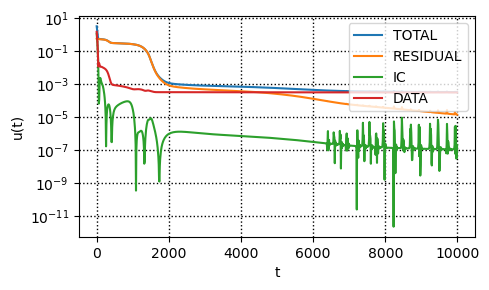

In [32]:
from pinn import Trainer

## Model
model = PINN(layer_sizes=[1, 20, 20, 1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.95)

## Training
loss_functions = {}
loss_functions["residual"] = residual_loss

targets = {}
targets["ic"] = t0, u0
targets["data"] = t_data, u_data

n_epochs = 10000
ivp = Trainer(model, optimizer, loss_functions, targets)
history = ivp.fit(t, n_epochs, scheduler=scheduler, update_step=20)
ivp.show_history()

### Evaluation

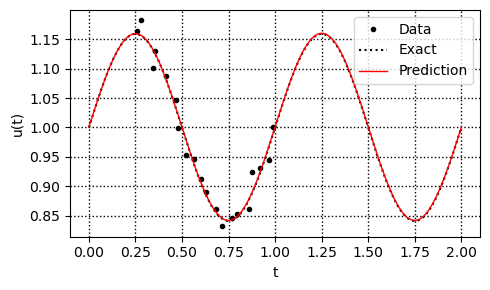

In [33]:
t_test_np = np.linspace(0, 2, 1001)
t_test = to_tensor(t_test_np)
u_pred = ivp.predict(t_test)

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(t_data_np, u_data_np, 'ko', ms=3, label="Data")
ax.plot(t_test_np, u_exact(t_test_np), 'k:', label="Exact")
ax.plot(t_test_np, u_pred, 'r', lw=1, label="Prediction")
ax.legend(loc="upper right")
ax.grid(color='k', ls=':', lw=1)
ax.set_xlabel("t")
ax.set_ylabel("u(t)")
fig.tight_layout()
plt.show()